# DAY2-1: 투자전략

In [3]:
#!brew install ta-lib
!pip install ta-lib

  Using cached TA-Lib-0.4.25.tar.gz (271 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build ta-lib


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [27 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-37
  creating build\lib.win-amd64-cpython-37\talib
  copying talib\abstract.py -> build\lib.win-amd64-cpython-37\talib
  copying talib\deprecated.py -> build\lib.win-amd64-cpython-37\talib
  copying talib\stream.py -> build\lib.win-amd64-cpython-37\talib
  copying talib\test_abstract.py -> build\lib.win-amd64-cpython-37\talib
  copying talib\test_data.py -> build\lib.win-amd64-cpython-37\talib
  copying talib\test_func.py -> build\lib.win-amd64-cpython-37\talib
  copying talib\test_pandas.py -> build\lib.win-amd64-cpython-37\talib
  copying talib\test_polars.py -> build\lib.win-amd64-cpython-37\talib
  copying talib\test_stream.py -> build\lib.win-amd64-cpython-37\talib
  copying talib\__init__.py -> build\lib.win-amd64-cpython-37\talib
  running build_ext
  building 'talib._ta_lib' extension
 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

import talib

# import pandas_datareader as pdr
import yfinance as yf

C:\Users\soeun\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Stock symbol
stock_symbol = "035420.KS"  # 네이버

# Load data
start_date = '2017-01-01' 
end_date = '2022-12-31'
#stockdata = pdr.DataReader(stock_symbol, 'yahoo', start_date, end_date)['Adj Close']
stockdata = yf.download(stock_symbol, start=start_date, end=end_date)["Adj Close"]

# Load close prices of to NumPy array
close = stockdata.values

[*********************100%***********************]  1 of 1 completed


In [3]:
def prepare_dataset(close, stocksymbol):
    """
    Function prepare_dataset to generate input data and trading strategy from stock close prices
    """

    macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)

    # Cancel NaN values
    macdhist = macdhist[~np.isnan(macdhist)]
    macd = macd[-len(macdhist):]
    macdsignal = macdsignal[-len(macdhist):]

    # Scaling features to a range [-1, 1]
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    macdhist_norm = min_max_scaler.fit_transform(np.expand_dims(macdhist, axis=1))

    # Implement strategy
    start_sell = 0.4
    stop_sell = 0.1
    start_buy = -0.4
    stop_buy = -0.1
    
    y = np.full(len(macdhist), np.nan)
    y[0] = 0

    for i in range(1, len(macdhist)):

        if y[i-1] == 0:
            if (macdhist_norm[i] >= start_sell):
                # Enter sell position
                y[i] = -1
            elif (macdhist_norm[i] <= start_buy):
                # Enter buy position
                y[i] = 1
            else:
                y[i] = 0
        elif y[i-1] == -1:
            if macdhist_norm[i] > stop_sell:
                # Stay in sell position
                y[i] = -1
            else:
                # Leave sell position
                y[i] = 0
        else:
            if macdhist_norm[i] < stop_buy:
                # Stay in buy position
                y[i] = 1
            else:
                # Leave buy position
                y[i] = 0
    
    # Plot strategy
    dates = np.arange(len(macdhist))
    plt.plot(dates, y,'g', label='Strategy Positions')
    plt.bar(dates, macdhist_norm[:, 0], width=1, color='blue', label='MACD histogram')
    plt.plot(dates, start_sell * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, stop_sell * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, start_buy * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, stop_buy * np.ones(len(macdhist)), 'k--', lw=1)
    plt.xlabel('Days')
    plt.xlim((0, 1500))
    plt.legend()
    stocksymbol = stocksymbol.split('.')[0]
    path = './DQN/images/' + stocksymbol + '_macd.png'  # c:/users/username/DQN/images/005930_macd.png
    plt.savefig(path, bbox_inches='tight')   
    plt.show()
    
    # Generate input data - technical indicators
    ind1 = talib.MIDPOINT(close)    # Overlap: MidPoint over period
    ind2 = talib.HT_DCPERIOD(close) # Cycle Indicator Functions:  Hilbert Transform - Dominant Cycle Period
    ind3 = talib.MAX(close)         # Math Operator: Highest value over a specified period
    ind4 = talib.SIN(close)         # Math Transform: Vector Trigonometric Sin
    ind5 = talib.APO(close)         # Momentum: Absolute Price Oscillator

    x = np.vstack((macdhist, macd, macdsignal, ind1[-len(macdhist):], ind2[-len(macdhist):],
                   ind3[-len(macdhist):], ind4[-len(macdhist):], ind5[-len(macdhist):]))
    x = x.T

    return x, y             

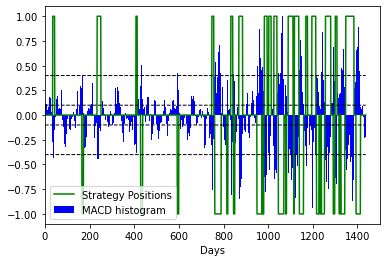

In [4]:
# Implement MACD trading strategy
X, y = prepare_dataset(close, stock_symbol)

In [5]:
# Split dataset
n_train = int(X.shape[0] * 0.8)

X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

In [6]:
# Normalize data
scaler = preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
y_train

array([ 0.,  0.,  0., ..., -1., -1., -1.])

In [8]:
# Encode trading signal with integers between 0 and n-1 classes
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(le.classes_)

[-1.  0.  1.]
